# 1. Functions

In [1]:
def standardize(parameter):
    """
    :param parameter: the array with the parameters you wish to standardize
    :return param_mean: mean of the input array
    :return param_std : standard deviation of the input array
    :return stdized_param: final standardized array
    """
    import numpy as np
    
    param_mean    = np.mean(parameter)
    param_std     = np.std(parameter)
    stdized_param = []                  # standardized parameter -- output
    for i in range(parameter.size):
        param_temp = (parameter[i] - param_mean)/param_std
        stdized_param.append(param_temp)
    stdized_param = np.array(stdized_param)
    return (param_mean, param_std, stdized_param)

In [2]:
def un_standardize(stdized_par, mean, std):
    """
    This function undoes what the former does!
    """
    
    import numpy as np
    
    recovered_par = []
    for i in range(stdized_par.size):
        param_temp = stdized_par[i]*std + mean
        recovered_par.append(param_temp)
    recovered_par = np.array(recovered_par)
    return (recovered_par)

In [3]:
def print_time(begin_time, end_time):
    """ 
    This function prints the time in minutes that a certain task took.
    """
    print ("--------------------------------------------------")
    print ("CPU process time: %.2f [min]" % float((end-start)/60))
    print ("--------------------------------------------------")

# 2. Packages

In [4]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import statsmodels.api   as sm
import seaborn           as sns
import arviz
import pystan
import time

In [5]:
my_data = pd.read_csv('../../Catalogue/binom_reg_dataset.csv')

In [6]:
# filtering the dataset
redshifts = my_data['Z']
index     = np.where(redshifts.values<=0.4)

# # parameters of interest
logit_class = my_data['LOGIT_CLASS(1-UVUP;0-UVWEAK)'].values[index].astype(int)    # y axis: logit class: UVUP yes/no
mass        = my_data['STELLAR_MASS'].values[index].astype(int)                    # 1st parameter
redshift    = redshifts.values[index].astype(float)                                # 2nd parameter

In [7]:
# original parameters
mean_mass, std_mass, x2 = standardize(mass)
x1      = redshift
y       = logit_class
n_obs   = x1.size

# new parameters - important for plotting!
n_obs2 = 30
x1_sim = np.linspace(x1.min(), x1.max(), n_obs2)
x2_sim = np.linspace(x2.min(), x2.max(), n_obs2)

# grid
plot_x1, plot_x2 = np.meshgrid(x1_sim, x2_sim)  # THIS IS WHERE THE GRID IS DONE
plot_x1 = plot_x1.reshape((n_obs2**2), 1)
plot_x2 = plot_x2.reshape((n_obs2**2), 1)

In [8]:
# dataset to be used in the regression
regression_data      = {}                                                 # Dictionary, as stated in the pystan manual
regression_data['Y'] = y
regression_data['X'] = sm.add_constant(np.column_stack((x1, x1**2, x2, x2**2)))
regression_data['K'] = 5                     # Number of betas -- b0, b1, b2, b3, b4
regression_data['N'] = n_obs

# dataset to be used in the plot -- after meshgrid
regression_data['X2'] = sm.add_constant(np.column_stack((plot_x1, plot_x1**2, plot_x2, plot_x2**2)))
regression_data['N2'] = n_obs2**2

In [9]:
# regression_data['X']

In [10]:
# sns.lmplot(x='STELLAR_MASS', y='LOGIT_CLASS(1-UVUP;0-UVWEAK)', data=my_data.iloc[index], logistic=True)
# plt.savefig('../../LargeFilesResults/Model/logistic_seaborn.pdf')
# plt.show()

### 2.1 Fit: STAN code 

In [11]:
stan_code = """
    data{
        int<lower=0> N;
        int<lower=0> N2;
        int<lower=0> K;
        int Y[N];
        matrix[N,K] X;
        matrix[N2,K] X2;
    }

    parameters{
        vector[K] beta;
    }

    transformed parameters{
        vector[N] eta;
        eta = X * beta;
    }

    model{
        Y ~ bernoulli_logit(eta);
    }

    generated quantities{
        vector[N2] etanew;
        real<lower=0, upper=1.0> pnew[N2];
        etanew = X2 * beta;
        for (j in 1:N2){
            pnew[j] = inv_logit(etanew[j]);
        }
    }
"""

### 2.2 Fit settings (for STAN)

In [12]:
iterations = 5000
chains     = 3                           # HMC chains
warmup     = 2000                        # How many of the first iterations we'll ignore - burnin
jobs       = -1                          # Run code in parallel -- see pystan documentation
seed       = 1

In [13]:
control = {}
control['max_treedepth'] = 15
control['adapt_delta'] = 0.9

### 2.3 Running the fit

In [14]:
start = time.time()

fit = pystan.stan(model_code=stan_code, data=regression_data, seed=seed, iter=iterations, chains=chains, warmup=warmup,
                  n_jobs=jobs, control=control)

end = time.time()
print_time(start, end)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9aeae9f053f6674eec0d58f69781a4c9 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


--------------------------------------------------
CPU process time: 1.66 [min]
--------------------------------------------------


# 3. Retrieving the data from the fit

### 3.1 Saving the entire fit: brace for impact!

In [15]:
start  = time.time()
fit_df = fit.to_dataframe()
end    = time.time()
print_time(start, end)

--------------------------------------------------
CPU process time: 0.02 [min]
--------------------------------------------------


In [16]:
start = time.time()
fit_df.to_csv('../../LargeFilesResults/Model/entirefit_noemlines.csv', index=False)
end   = time.time()
print_time(start, end)

--------------------------------------------------
CPU process time: 0.67 [min]
--------------------------------------------------


In [17]:
posteriors = fit_df[fit.flatnames[:5]]
header_posteriors = fit.flatnames[:5]

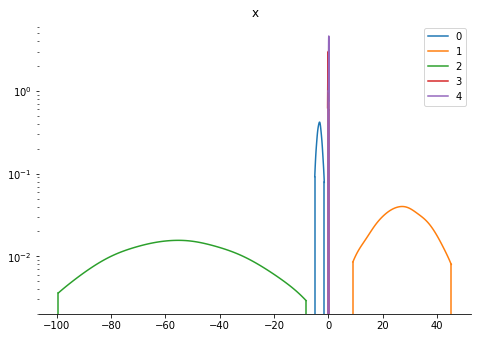

In [18]:
arviz.plot_density(data=[fit['beta[1]'], fit['beta[2]'], fit['beta[3]'], fit['beta[4]'], fit['beta[5]']])
plt.yscale('log')
plt.show()

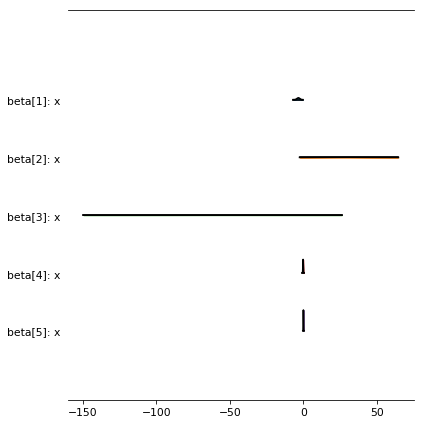

In [19]:
arviz.plot_forest(data=[fit['beta[1]'], fit['beta[2]'], fit['beta[3]'], fit['beta[4]'], fit['beta[5]']], 
                  kind='ridgeplot', model_names=['beta[1]', 'beta[2]', 'beta[3]', 'beta[4]', 'beta[5]'],
                  r_hat=False, n_eff=False, figsize=(6,6))
plt.tight_layout()
# plt.savefig('../../LargeFilesResults/Model/betas_forest05.png', dpi=150, bbox_inches='tight')
plt.show()

In [20]:
figsize=(6,3)

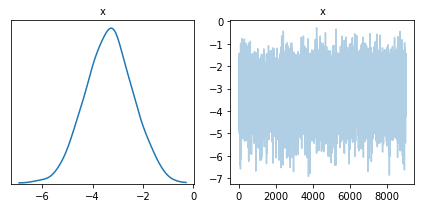

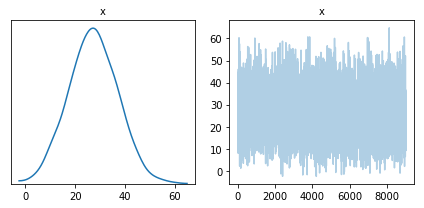

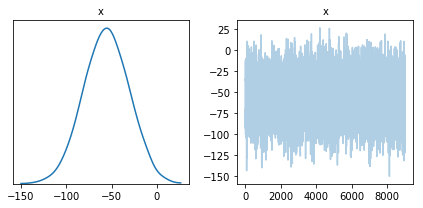

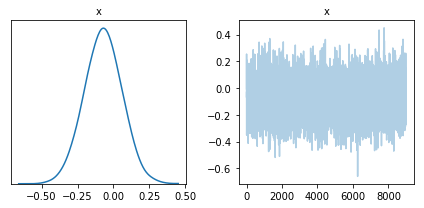

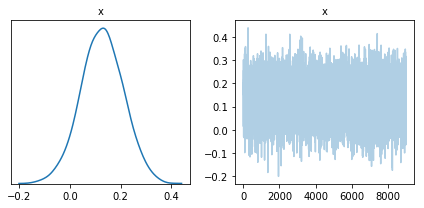

In [21]:
plot = arviz.plot_trace(data=fit['beta[1]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[2]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[3]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[4]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[5]'], figsize=figsize)
plt.tight_layout()
# plt.savefig('../../LargeFilesResults/Model/trace_class01.pdf', bbox_inches='tight')
plt.show()

### 3.2 Saving the automatic summary from STAN

In [22]:
summary = pystan.stansummary(fit=fit, digits_summary=3)

In [23]:
summary_arr  = np.array(summary.split('\n'))
summary_clean = summary_arr[5:-6,]

In [24]:
header_fit = ['parameter'] + summary_arr[4].split()

#### 3.2.1 Recovering the mass (undo the stadardization) and adding x1 and x2 to the summary

In [25]:
recovered_mass  = un_standardize(stdized_par=plot_x2, mean=mean_mass, std=std_mass)
recovered_pars  = np.column_stack((np.squeeze(plot_x1), np.squeeze(recovered_mass)))
rp = recovered_pars

In [26]:
rp

array([[ 0.06794   ,  9.        ],
       [ 0.07760759,  9.        ],
       [ 0.08727517,  9.        ],
       ...,
       [ 0.32896483, 11.        ],
       [ 0.33863241, 11.        ],
       [ 0.3483    , 11.        ]])

#### 3.2.2 Checking if the numbers aren't overlaped

In [28]:
new_summary = list(np.zeros(len(header_fit)))
for i in range(summary_clean.size):
    if len(summary_clean[i].split())!=11:   # the length of the list must be 11, in which case we connect them directly
        new_summ_temp = np.array(summary_clean[i].split())
        new_summ_temp = np.concatenate((new_summ_temp, ['X']))
        new_summary   = np.vstack((new_summary, new_summ_temp))
#         new_summary   = np.vstack((new_summary, np.concatenate((new_summ_temp, ['X']))))
        print ('new_summary[%d] = ' %i, "'%s'," %summary_clean[i])
    else:
        new_summ_temp = np.array(summary_clean[i].split()).reshape(1,11)
        new_summary   = np.vstack((new_summary, new_summ_temp))
new_summary = new_summary[1:,:]            # removing the zeroes in the beggining
print (new_summary[:,0].shape)

new_summary[26] =  'eta[22]      0.136   0.003  0.197 -0.245-5.02e-5  0.138  0.271  0.527   5312    1.0',
new_summary[311] =  'eta[307]     0.131   0.002  0.196 -0.257-7.08e-4  0.131  0.264  0.518   7542  1.001',
new_summary[927] =  'etanew[419] -0.401   0.009  0.594 -1.536 -0.803 -0.409-7.59e-4   0.77   4005    1.0',
new_summary[1298] =  'etanew[790] -0.381   0.003  0.197 -0.772 -0.512 -0.379  -0.25-6.26e-4   5833    1.0',
(2309,)


In [29]:
new_summary[26]   =  ['eta[22]', '0.136', '0.003', '0.197', '-0.245', '-5.02e-5', '0.138', '0.271', '0.527', '5312',' 1.0']
new_summary[311]  =  ['eta[307]', '0.131', '0.002', '0.196', '-0.257', '-7.08e-4', '0.131', '0.264', '0.518', '7542',  '1.001']
new_summary[927]  =  ['etanew[419]', '-0.401', '0.009', '0.594', '-1.536', '-0.803', '-0.409', '-7.59e-4', '0.77', '4005', '1.0']
new_summary[1298] =  ['etanew[790]', '-0.381', '0.003', '0.197', '-0.772', '-0.512', '-0.379', '-0.25', '-6.26e-4', '5833', '1.0']

#### 3.2.3 Retrieving only the probabilities from the summary and stacking x1 and x2 at the end of the dataframe

In [30]:
new_summary

array([['beta[1]', '-3.344', '0.021', ..., '-1.495', '2119', '1.002'],
       ['beta[2]', '27.231', '0.215', ..., '46.347', '2080', '1.002'],
       ['beta[3]', '-55.76', '0.532', ..., '-8.311', '2167', '1.002'],
       ...,
       ['pnew[898]', '0.447', '0.002', ..., '0.651', '3465', '1.001'],
       ['pnew[899]', '0.425', '0.002', ..., '0.658', '3278', '1.001'],
       ['pnew[900]', '0.402', '0.002', ..., '0.662', '3140', '1.001']],
      dtype='<U32')

In [31]:
tosave = np.column_stack([new_summary[1409:, :], rp])

In [32]:
probs = pd.DataFrame(tosave)

In [33]:
model_results_df = pd.DataFrame(tosave)
model_results_df.columns = header_fit + ['Z', 'LOG_STELLAR_MASS']
model_results_df.to_csv('../../LargeFilesResults/Model/fit_summ_noemlines.csv', header=True, index=False)

In [34]:
model_results_df

,parameter,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat,Z,LOG_STELLAR_MASS
0,pnew[1],0.34,0.002,0.129,0.12,0.246,0.329,0.424,0.619,4516,1.0,0.06794,9.0
1,pnew[2],0.379,0.002,0.134,0.142,0.283,0.37,0.468,0.659,4432,1.0,0.07760758620689655,9.0
2,pnew[3],0.418,0.002,0.137,0.164,0.319,0.412,0.513,0.698,4267,1.0,0.0872751724137931,9.0
3,pnew[4],0.455,0.002,0.14,0.187,0.354,0.453,0.554,0.73,4064,1.0,0.09694275862068966,9.0
4,pnew[5],0.49,0.002,0.143,0.211,0.388,0.491,0.592,0.764,3854,1.0,0.1066103448275862,9.0
5,pnew[6],0.523,0.002,0.145,0.232,0.422,0.527,0.627,0.791,3660,1.0,0.11627793103448275,9.0
6,pnew[7],0.553,0.002,0.146,0.254,0.451,0.56,0.659,0.814,3493,1.001,0.1259455172413793,9.0
7,pnew[8],0.58,0.003,0.146,0.274,0.48,0.589,0.687,0.836,3355,1.001,0.13561310344827587,9.0
8,pnew[9],0.604,0.003,0.146,0.293,0.506,0.616,0.712,0.856,3245,1.001,0.1452806896551724,9.0
9,pnew[10],0.626,0.003,0.146,0.31,0.529,0.639,0.734,0.87,3158,1.001,0.15494827586206894,9.0


In [35]:
posteriors = fit_df[fit.flatnames[:5]]

In [36]:
fit_df.keys()

Index(['chain', 'draw', 'warmup', 'beta[1]', 'beta[2]', 'beta[3]', 'beta[4]',
       'beta[5]', 'eta[1]', 'eta[2]',
       ...
       'pnew[898]', 'pnew[899]', 'pnew[900]', 'lp__', 'accept_stat__',
       'stepsize__', 'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__'],
      dtype='object', length=2319)

In [37]:
fit_df['treedepth__'].describe()

count    9000.000000
mean        5.600000
std         1.087667
min         1.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         7.000000
Name: treedepth__, dtype: float64

In [38]:
fit_df['n_leapfrog__'].describe()

count    9000.000000
mean       78.395333
std        43.236814
min         3.000000
25%        51.000000
50%        63.000000
75%       127.000000
max       255.000000
Name: n_leapfrog__, dtype: float64

In [39]:
posteriors.to_csv('../../LargeFilesResults/Model/posteriors_noemlines.csv', index=False)

In [40]:
posteriors

,beta[1],beta[2],beta[3],beta[4],beta[5]
0,-3.627605,26.543010,-49.416825,-0.178639,0.206105
1,-2.937605,24.334813,-50.771761,-0.221983,0.129558
2,-3.557714,30.401969,-63.817498,-0.176406,0.159217
3,-4.736805,41.003941,-86.472234,-0.075757,0.107673
4,-4.000744,33.075963,-71.288262,-0.274525,0.270585
5,-4.154682,33.428959,-67.229539,-0.148072,0.240192
6,-4.025046,33.091481,-67.687195,-0.290297,0.186689
7,-4.415295,33.207247,-58.542623,-0.321354,0.171506
8,-3.768032,32.704884,-70.122145,-0.290353,0.168735
9,-3.969980,32.688716,-67.873276,-0.318083,0.158299


In [41]:
diagnostics = pystan.check_hmc_diagnostics(fit, per_chain=True)

In [42]:
diagnostics

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [43]:
model_results_df['Rhat'].max()

'1.001'

In [44]:
model_results_df['Rhat'].min()

'1.0'